In [1]:
# import tensorflow #added
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
# from keras.constraints import maxnorm # added
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import imageio #added
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190925111443-0001
KERNEL_ID = 5e256628-b044-4651-ac94-05f1a554fc89


Using TensorFlow backend.


In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='9d918399-9d95-414e-aa5c-daf8ef31dfdc', project_access_token='p-a8cd5a1bcde068e94f4e60aa71cd0e9ef38c19d3')
pc = project.project_context


In [3]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-4656ffec-3252-4767-ad5d-0e069a230dcb',
    'IBM_API_KEY_ID': '0ksNc3JihyJ6vPocWJDSf6HHIt_A8pXy3_0L6mJDN5ng',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'genresuggestionbookcovers-donotdelete-pr-vmwzgrygcslv4f',
    'FILE': 'Dataset.zip'
}


In [4]:
import zipfile
def get_zip(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        fobj = open(file_name, "wb")
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully') 

In [5]:
get_zip('Dataset.zip')

Files downloaded successfully


In [6]:
train = pd.read_csv(project.get_file('train.csv'))
train.head()

,Id,Genre,Crime,Fantasy,Horror,Novel,Romance,Sci-Fi,Thriller
0,9780297851530.jpg,['Crime'],1,0,0,0,0,0,0
1,9780297852544.jpg,['Crime'],1,0,0,0,0,0,0
2,9780316043786.jpg,['Fantasy'],0,1,0,0,0,0,0
3,9780316076968.jpg,['Fantasy'],0,1,0,0,0,0,0
4,9780316077347.jpg,['Novel'],0,0,0,1,0,0,0


In [7]:
train.columns

Index(['Id', 'Genre', 'Crime', 'Fantasy', 'Horror', 'Novel', 'Romance',
       'Sci-Fi', 'Thriller'],
      dtype='object')

In [ ]:
heights = []
widths = []
for i in tqdm(range(train.shape[0])):
     img = image.load_img('Dataset/'+train['Id'][i])  
     img = image.img_to_array(img)
     heights.append(img.shape[0])
     widths.append(img.shape[1])

avg_height = sum(heights) / len(heights)
avg_width = sum(widths) / len(widths)
print("Average Height: " + str(avg_height))
print("Max Height: " + str(max(heights)))
print("Min Height: " + str(min(heights)))
print("Average Width: " + str(avg_width))
print("Max Width: " + str(max(widths)))
print("Min Width: " + str(min(widths)))

In [9]:
IMG_SIZE = 400

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('Dataset/'+train['Id'][i], target_size=(IMG_SIZE,IMG_SIZE,3)) #from (400,400,3) Height,width
    img = image.img_to_array(img)
#    img = img.resize((IMG_SIZE, IMG_SIZE)) #, img.ANTIALIAS)
    img = img.astype('float32') #added
    img = img/255 #from 255 number of pixels
    train_image.append(img)
  
    
X = np.array(train_image)

100%|██████████| 350/350 [00:04<00:00, 80.93it/s]


In [10]:
X.shape

(350, 400, 400, 3)

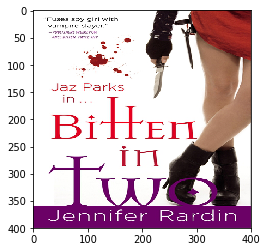

In [11]:
plt.imshow(X[2])

In [12]:
train['Genre'][2]

"['Fantasy']"

In [13]:
y = np.array(train.drop(['Id', 'Genre'],axis=1))
y.shape

(350, 7)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [19]:
model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='sigmoid'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 199, 199, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 197, 197, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 64)        18496     
__________

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8) #batch from 64 epoch from 10

Instructions for updating:
Use tf.cast instead.


Train on 315 samples, validate on 35 samples
Epoch 1/10
315/315 [==============================] - 18s 58ms/step - loss: 0.5788 - acc: 0.7342 - val_loss: 0.5261 - val_acc: 0.8571
Epoch 2/10
315/315 [==============================] - 16s 50ms/step - loss: 0.4802 - acc: 0.8259 - val_loss: 0.4914 - val_acc: 0.8571
Epoch 3/10
315/315 [==============================] - 15s 48ms/step - loss: 0.4698 - acc: 0.8381 - val_loss: 0.4945 - val_acc: 0.8571
Epoch 4/10
315/315 [==============================] - 15s 48ms/step - loss: 0.4551 - acc: 0.8485 - val_loss: 0.4575 - val_acc: 0.8571
Epoch 5/10
315/315 [==============================] - 15s 49ms/step - loss: 0.4546 - acc: 0.8549 - val_loss: 0.4336 - val_acc: 0.8571
Epoch 6/10
315/315 [==============================] - 16s 49ms/step - loss: 0.4494 - acc: 0.8535 - val_loss: 0.4256 - val_acc: 0.8571
Epoch 7/10
315/315 [==============================] - 15s 48ms/step - loss: 0.4425 - acc: 0.8571 - val_loss: 0.4171 - val_acc: 0.8571
Epoch 8/10
315/31

In [23]:
img = image.load_img('Dataset/9781472107329.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

Crime (0.248)
Horror (0.235)
Sci-Fi (0.213)


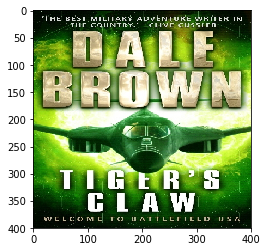

In [25]:
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)